In [1]:
import tensorflow as tf

# IMPORTANTE: Dejad este conjunto de lineas #
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
#############################################

Num GPUs Available:  2


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
datapath = "data/pvpcdata.csv"
day = 24

In [4]:
df = pd.read_csv(datapath, sep = ";")

In [5]:
#Due to the hour format is between 0 to 23, we need to transform it
for i in df.index:
        df.at[i, 'hour'] = df.at[i, 'hour'] - 1

In [6]:
#To keep only valid valued, not the unusual ones
df = df.loc[df['hour'] < 24]

In [7]:
cols = ["year","month","day"]
df['date'] = df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")

In [8]:
df.head()

,year,month,day,hour,price,date
0,2017,1,1,0,58.82,2017-1-1
1,2017,1,1,1,58.23,2017-1-1
2,2017,1,1,2,51.95,2017-1-1
3,2017,1,1,3,47.27,2017-1-1
4,2017,1,1,4,46.90,2017-1-1


In [9]:
df['date'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['hour'].astype(str) + ":00:00")

In [10]:
df = df.loc[df.date >= '2021-12-01 00:00:00']

[Text(0.5, 1.0, 'Energy prices per hour at the last day')]

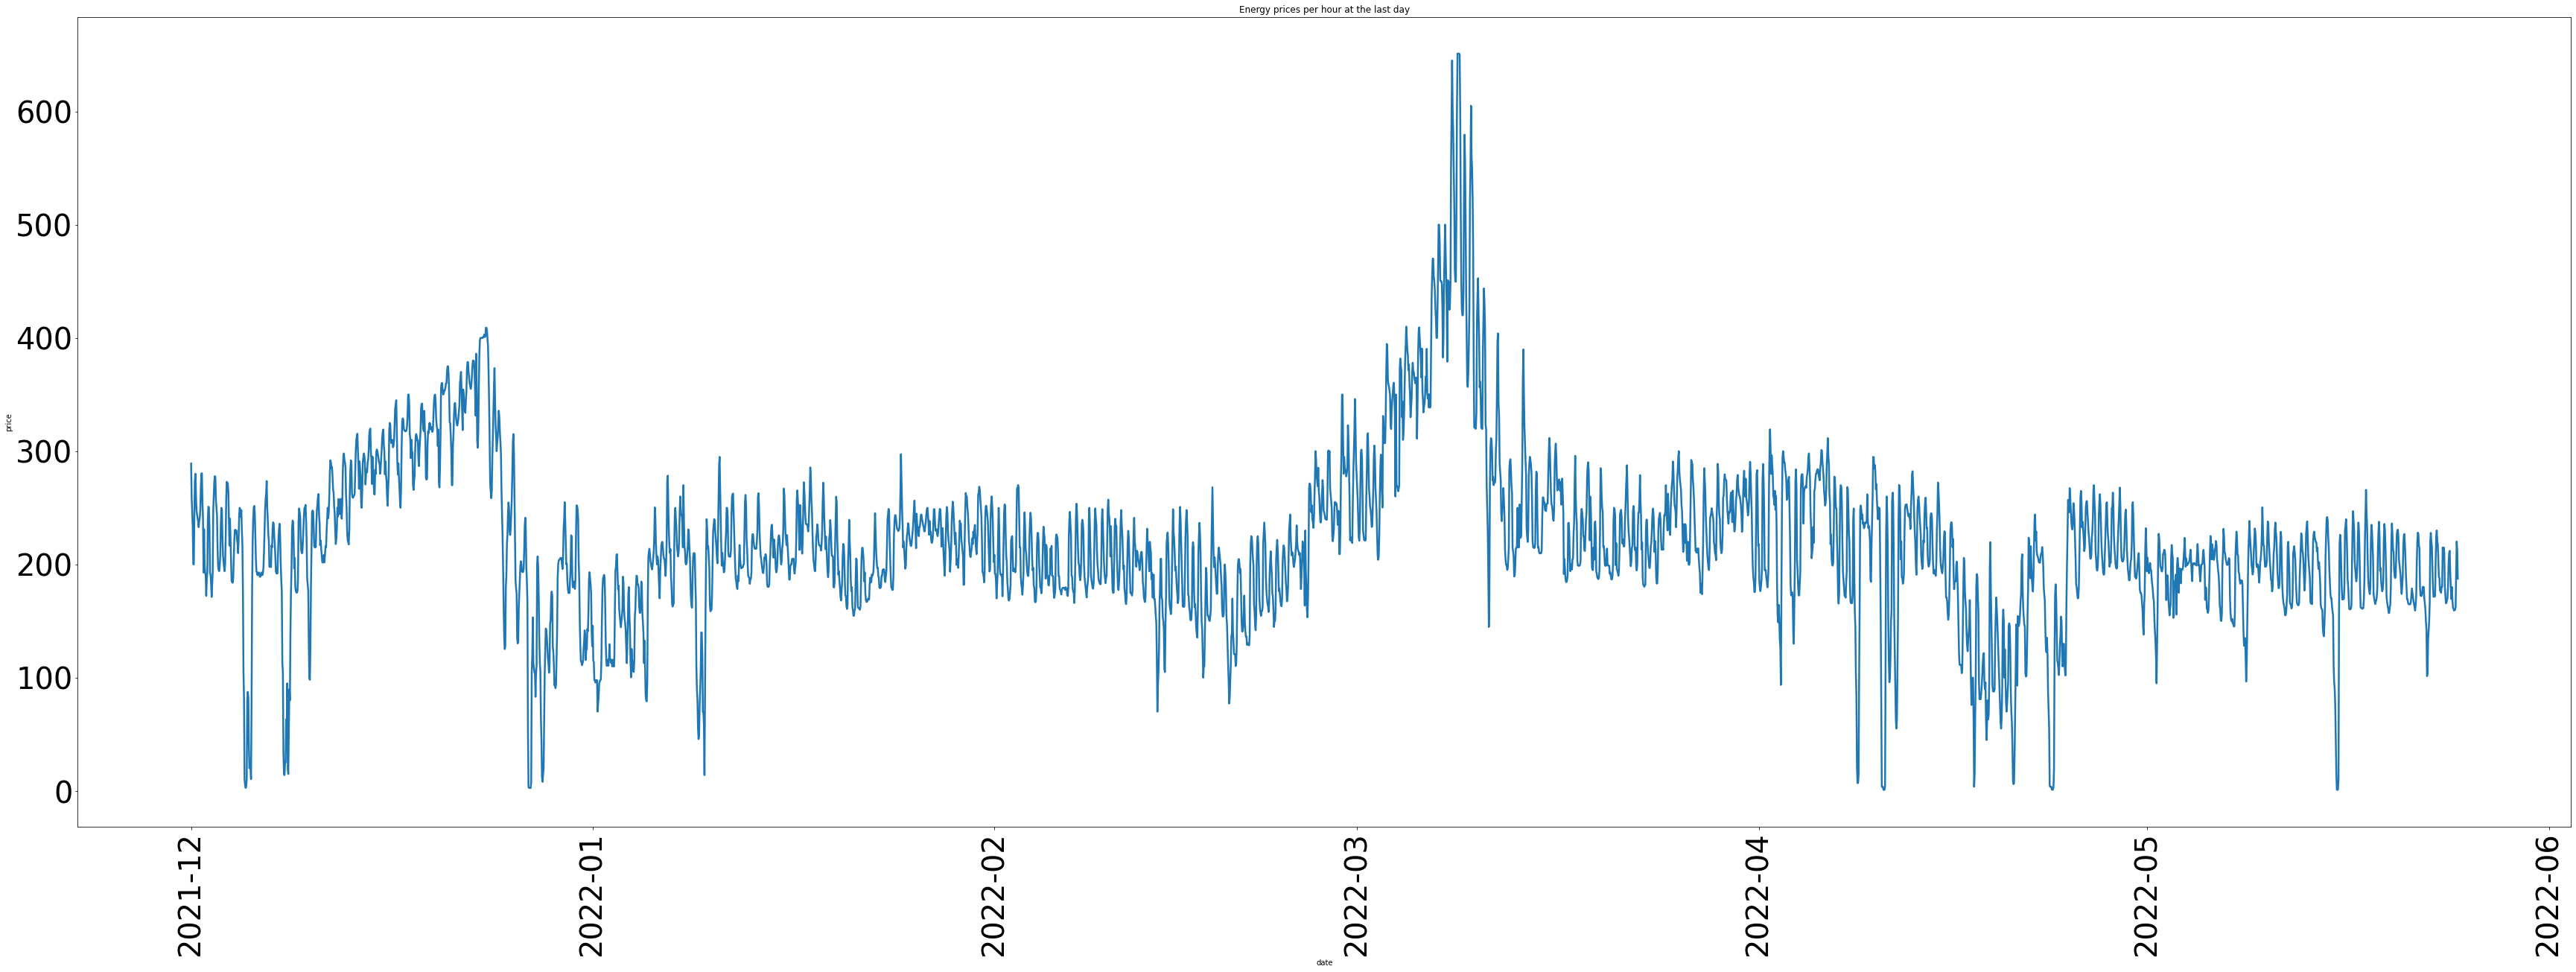

In [11]:
fig, ax = plt.subplots(figsize=(60,20))
plt.xticks(rotation=90, fontsize = 40)
plt.yticks(fontsize = 40)
sns.lineplot(x = 'date', y = 'price', data = df, linewidth = 2.5, ax = ax).set(title='Energy prices per hour at the last day')

In [12]:
df = df[['date', 'price']]

In [13]:
date = df.pop('date')

In [14]:
timestamp = date.map(datetime.datetime.timestamp)

In [15]:
sec_day = 24*60*60
sec_week = 7 * day
sec_year = 365.2425 * day

df['day_sin'] = np.sin(timestamp * (2*np.pi / sec_day))
df['day_cos'] = np.cos(timestamp * (2*np.pi / sec_day))
df['week_sin'] = np.sin(timestamp * (2*np.pi / sec_week))
df['week_cos'] = np.cos(timestamp * (2*np.pi / sec_week))
df['year_sin'] = np.sin(timestamp * (2*np.pi / sec_year))
df['year_cos'] = np.cos(timestamp * (2*np.pi / sec_year))

#Tamaño de ventana (normalmente 3 * salida)
w_size = 3 
#Número de entradas
n_inputs = len(df.columns)

In [16]:
# Método de la ventana, parámetro único en X
# Aquí podemos ver como dadas 5 horas, predice la siguiente
# [[P1, DS1, DC1, YS1, YC1],[P2...],[P3...],[P4...],[P5...] --> [P6]
# [P2,P3,P4,P5,P6] --> [P7]

def df_to_x_y_multiple(df, w_size):
    df_as_np = df.to_numpy()
    x = []
    y = []
    
    #Bucle para construir nuestra ventana simple
    for i in range(len(df_as_np) - w_size):
        row = [r for r in df_as_np[i:i + w_size]]
        x.append(row)
        
        #Solo queremos el precio
        label = df_as_np[i + w_size][0]
        y.append(label)
    
    y_array = np.array(y)
    return np.array(x), y_array.reshape((y_array.size,1))

In [17]:
x, y = df_to_x_y_multiple(df, w_size)
x.shape, y.shape

((4196, 3, 7), (4196, 1))

In [18]:
x_train, x_aux, y_train, y_aux = train_test_split(x, y, test_size = 0.3, shuffle=False)
x_test, x_val, y_test, y_val = train_test_split(x_aux, y_aux, test_size = 0.33, shuffle=False)

In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2937, 3, 7), (2937, 1), (843, 3, 7), (843, 1), (416, 3, 7), (416, 1))

In [97]:
x_mean = np.mean(x[:, :, 0])
x_std = np.std(x[:, :, 0])
y_mean = np.mean(y[:, 0])
y_std = np.std(y[:, 0])
print(x_mean)
print(x_std)
print(y_mean)
print(y_std)

219.2320209723546
73.79958332698291
219.20504051477596
73.7957600632383


In [21]:
def standarize_input(df):
    df[:, :, 0] = (df[:, :, 0] - x_mean) / x_std
    return df

def standarize_output(df):
    df[:, 0] = (df[:, 0] - y_mean) / y_std
    return df

In [22]:
x_train_norm = standarize_input(x_train)
x_test_norm = standarize_input(x_test)
x_val_norm = standarize_input(x_val)
y_train_norm = standarize_output(y_train)
y_test_norm = standarize_output(y_test)
y_val_norm = standarize_output(y_val)


In [23]:
def build_model_lstm():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [24]:
def build_model_lstm_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [25]:
def build_model_cnn():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [26]:
def build_model_cnn_relu():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Conv1D(64, kernel_size = 2, activation = 'relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [27]:
def build_model_gru():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [28]:
def build_model_gru_ret_seq():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.GRU(64, return_sequences = True))
    model.add(tf.keras.layers.GRU(32))
    model.add(tf.keras.layers.Dense(8, 'relu'))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [29]:
def build_model_lstm_unrestricted():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [30]:
def build_model_lstm_dropout():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True, recurrent_dropout = 0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [31]:
def build_model_lstm_go_bwd():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.LSTM(64, return_sequences = True, go_backwards = True))
    model.add(tf.keras.layers.LSTM(32, return_sequences = True))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [32]:
def build_model_lstm_bidirectional():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer((w_size, n_inputs)))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, 'linear'))
    model.compile(
        loss = 'mean_squared_error',
        optimizer = tf.keras.optimizers.Adam(0.001),
        metrics = ['mae', 'mse']
    )
    return model

In [33]:
model_lstm = build_model_lstm()

2022-06-16 09:52:53.445500: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-16 09:52:54.446376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 27318 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5b:00.0, compute capability: 7.0
2022-06-16 09:52:54.447602: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 29568 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d7:00.0, compute capability: 7.0


In [34]:
model_cnn = build_model_cnn()
model_gru = build_model_gru()
model_lstm_ret_seq = build_model_lstm_ret_seq()
model_cnn_relu = build_model_cnn_relu()
model_lstm_unrestricted = build_model_lstm_unrestricted()
model_lstm_dropout = build_model_lstm_dropout()
model_lstm_go_bwd = build_model_lstm_go_bwd()
model_lstm_bi = build_model_lstm_bidirectional()

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='auto', restore_best_weights=True, patience=15)

In [36]:
history_lstm = model_lstm.fit(
    x_train_norm,
    y_train,
    validation_data = (x_val_norm, y_val),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500


2022-06-16 09:52:57.921106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100


92/92 [==============================] - 3s 11ms/step - loss: 0.8652 - mae: 0.6079 - mse: 0.8652 - val_loss: 0.1584 - val_mae: 0.3106 - val_mse: 0.1584
Epoch 2/500
92/92 [==============================] - 1s 8ms/step - loss: 0.3334 - mae: 0.3915 - mse: 0.3334 - val_loss: 0.1323 - val_mae: 0.2749 - val_mse: 0.1323
Epoch 3/500
92/92 [==============================] - 1s 8ms/step - loss: 0.1563 - mae: 0.2729 - mse: 0.1563 - val_loss: 0.1010 - val_mae: 0.2288 - val_mse: 0.1010
Epoch 4/500
92/92 [==============================] - 1s 8ms/step - loss: 0.1188 - mae: 0.2381 - mse: 0.1188 - val_loss: 0.0779 - val_mae: 0.1980 - val_mse: 0.0779
Epoch 5/500
92/92 [==============================] - 1s 8ms/step - loss: 0.0998 - mae: 0.2176 - mse: 0.0998 - val_loss: 0.0765 - val_mae: 0.2045 - val_mse: 0.0765
Epoch 6/500
92/92 [==============================] - 1s 8ms/step - loss: 0.0876 - mae: 0.2059 - mse: 0.0876 - val_loss: 0.0691 - val_mae: 0.1887 - val_mse: 0.0691
Epoch 7/500
92/92 [==============

In [37]:
history_lstm_ret_seq = model_lstm_ret_seq.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 3s 16ms/step - loss: 0.8583 - mae: 0.6141 - mse: 0.8583 - val_loss: 0.1829 - val_mae: 0.3451 - val_mse: 0.1829
Epoch 2/500
92/92 [==============================] - 1s 10ms/step - loss: 0.2884 - mae: 0.3904 - mse: 0.2884 - val_loss: 0.1517 - val_mae: 0.2857 - val_mse: 0.1517
Epoch 3/500
92/92 [==============================] - 1s 10ms/step - loss: 0.1961 - mae: 0.3147 - mse: 0.1961 - val_loss: 0.1054 - val_mae: 0.2260 - val_mse: 0.1054
Epoch 4/500
92/92 [==============================] - 1s 10ms/step - loss: 0.1512 - mae: 0.2752 - mse: 0.1512 - val_loss: 0.0902 - val_mae: 0.2190 - val_mse: 0.0902
Epoch 5/500
92/92 [==============================] - 1s 10ms/step - loss: 0.1261 - mae: 0.2520 - mse: 0.1261 - val_loss: 0.0904 - val_mae: 0.2266 - val_mse: 0.0904
Epoch 6/500
92/92 [==============================] - 1s 10ms/step - loss: 0.1118 - mae: 0.2370 - mse: 0.1118 - val_loss: 0.0847 - val_mae: 0.2178 - val_mse: 0.0847
Epoch 7/500
92/9

In [38]:
history_cnn = model_cnn.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 1s 7ms/step - loss: 0.3292 - mae: 0.4167 - mse: 0.3292 - val_loss: 0.1198 - val_mae: 0.2601 - val_mse: 0.1198
Epoch 2/500
92/92 [==============================] - 1s 6ms/step - loss: 0.1411 - mae: 0.2759 - mse: 0.1411 - val_loss: 0.0737 - val_mae: 0.2002 - val_mse: 0.0737
Epoch 3/500
92/92 [==============================] - 1s 6ms/step - loss: 0.0990 - mae: 0.2294 - mse: 0.0990 - val_loss: 0.0631 - val_mae: 0.1837 - val_mse: 0.0631
Epoch 4/500
92/92 [==============================] - 1s 6ms/step - loss: 0.0846 - mae: 0.2113 - mse: 0.0846 - val_loss: 0.0647 - val_mae: 0.1916 - val_mse: 0.0647
Epoch 5/500
92/92 [==============================] - 1s 6ms/step - loss: 0.0781 - mae: 0.2026 - mse: 0.0781 - val_loss: 0.0643 - val_mae: 0.1937 - val_mse: 0.0643
Epoch 6/500
92/92 [==============================] - 1s 6ms/step - loss: 0.0703 - mae: 0.1895 - mse: 0.0703 - val_loss: 0.0583 - val_mae: 0.1841 - val_mse: 0.0583
Epoch 7/500
92/92 [===

In [39]:
history_cnn_relu = model_cnn_relu.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 1s 6ms/step - loss: 0.9397 - mae: 0.6503 - mse: 0.9397 - val_loss: 0.2062 - val_mae: 0.3720 - val_mse: 0.2062
Epoch 2/500
92/92 [==============================] - 1s 6ms/step - loss: 0.3103 - mae: 0.3759 - mse: 0.3103 - val_loss: 0.0967 - val_mae: 0.2380 - val_mse: 0.0967
Epoch 3/500
92/92 [==============================] - 1s 6ms/step - loss: 0.1156 - mae: 0.2367 - mse: 0.1156 - val_loss: 0.0600 - val_mae: 0.1716 - val_mse: 0.0600
Epoch 4/500
92/92 [==============================] - 1s 6ms/step - loss: 0.0826 - mae: 0.1977 - mse: 0.0826 - val_loss: 0.0520 - val_mae: 0.1671 - val_mse: 0.0520
Epoch 5/500
92/92 [==============================] - 1s 6ms/step - loss: 0.0722 - mae: 0.1853 - mse: 0.0722 - val_loss: 0.0488 - val_mae: 0.1631 - val_mse: 0.0488
Epoch 6/500
92/92 [==============================] - 1s 6ms/step - loss: 0.0651 - mae: 0.1773 - mse: 0.0651 - val_loss: 0.0465 - val_mae: 0.1595 - val_mse: 0.0465
Epoch 7/500
92/92 [===

In [40]:
history_gru = model_gru.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 2s 11ms/step - loss: 0.4749 - mae: 0.4664 - mse: 0.4749 - val_loss: 0.1019 - val_mae: 0.2349 - val_mse: 0.1019
Epoch 2/500
92/92 [==============================] - 1s 8ms/step - loss: 0.1294 - mae: 0.2556 - mse: 0.1294 - val_loss: 0.0708 - val_mae: 0.1820 - val_mse: 0.0708
Epoch 3/500
92/92 [==============================] - 1s 8ms/step - loss: 0.0968 - mae: 0.2153 - mse: 0.0968 - val_loss: 0.0582 - val_mae: 0.1724 - val_mse: 0.0582
Epoch 4/500
92/92 [==============================] - 1s 7ms/step - loss: 0.0794 - mae: 0.1957 - mse: 0.0794 - val_loss: 0.0526 - val_mae: 0.1677 - val_mse: 0.0526
Epoch 5/500
92/92 [==============================] - 1s 8ms/step - loss: 0.0679 - mae: 0.1813 - mse: 0.0679 - val_loss: 0.0501 - val_mae: 0.1638 - val_mse: 0.0501
Epoch 6/500
92/92 [==============================] - 1s 8ms/step - loss: 0.0607 - mae: 0.1711 - mse: 0.0607 - val_loss: 0.0471 - val_mae: 0.1595 - val_mse: 0.0471
Epoch 7/500
92/92 [==

In [41]:
history_lstm_unrestricted = model_lstm_unrestricted.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 4s 16ms/step - loss: 0.6993 - mae: 0.5781 - mse: 0.6993 - val_loss: 0.1865 - val_mae: 0.3437 - val_mse: 0.1865
Epoch 2/500
92/92 [==============================] - 1s 10ms/step - loss: 0.2587 - mae: 0.3679 - mse: 0.2587 - val_loss: 0.1619 - val_mae: 0.3016 - val_mse: 0.1619
Epoch 3/500
92/92 [==============================] - 1s 9ms/step - loss: 0.2010 - mae: 0.3225 - mse: 0.2010 - val_loss: 0.1268 - val_mae: 0.2567 - val_mse: 0.1268
Epoch 4/500
92/92 [==============================] - 1s 10ms/step - loss: 0.1558 - mae: 0.2803 - mse: 0.1558 - val_loss: 0.1007 - val_mae: 0.2244 - val_mse: 0.1007
Epoch 5/500
92/92 [==============================] - 1s 10ms/step - loss: 0.1287 - mae: 0.2543 - mse: 0.1287 - val_loss: 0.0957 - val_mae: 0.2228 - val_mse: 0.0957
Epoch 6/500
92/92 [==============================] - 1s 10ms/step - loss: 0.1179 - mae: 0.2446 - mse: 0.1179 - val_loss: 0.0912 - val_mae: 0.2196 - val_mse: 0.0912
Epoch 7/500
92/92

In [42]:
history_lstm_dropout = model_lstm_dropout.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 6s 40ms/step - loss: 0.7583 - mae: 0.5977 - mse: 0.7583 - val_loss: 0.1865 - val_mae: 0.3438 - val_mse: 0.1865
Epoch 2/500
92/92 [==============================] - 3s 37ms/step - loss: 0.3029 - mae: 0.3986 - mse: 0.3029 - val_loss: 0.1688 - val_mae: 0.3130 - val_mse: 0.1688
Epoch 3/500
92/92 [==============================] - 3s 38ms/step - loss: 0.2444 - mae: 0.3572 - mse: 0.2444 - val_loss: 0.1447 - val_mae: 0.2833 - val_mse: 0.1447
Epoch 4/500
92/92 [==============================] - 3s 38ms/step - loss: 0.2288 - mae: 0.3369 - mse: 0.2288 - val_loss: 0.1181 - val_mae: 0.2500 - val_mse: 0.1181
Epoch 5/500
92/92 [==============================] - 3s 38ms/step - loss: 0.1837 - mae: 0.3042 - mse: 0.1837 - val_loss: 0.1017 - val_mae: 0.2272 - val_mse: 0.1017
Epoch 6/500
92/92 [==============================] - 3s 37ms/step - loss: 0.1677 - mae: 0.2914 - mse: 0.1677 - val_loss: 0.0907 - val_mae: 0.2155 - val_mse: 0.0907
Epoch 7/500
92/9

In [43]:
history_lstm_go_bwd = model_lstm_go_bwd.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 3s 17ms/step - loss: 0.5352 - mae: 0.4962 - mse: 0.5352 - val_loss: 0.1088 - val_mae: 0.2475 - val_mse: 0.1088
Epoch 2/500
92/92 [==============================] - 1s 11ms/step - loss: 0.1563 - mae: 0.2764 - mse: 0.1563 - val_loss: 0.0858 - val_mae: 0.2050 - val_mse: 0.0858
Epoch 3/500
92/92 [==============================] - 1s 11ms/step - loss: 0.1306 - mae: 0.2590 - mse: 0.1306 - val_loss: 0.0726 - val_mae: 0.1855 - val_mse: 0.0726
Epoch 4/500
92/92 [==============================] - 1s 11ms/step - loss: 0.1154 - mae: 0.2457 - mse: 0.1154 - val_loss: 0.0648 - val_mae: 0.1837 - val_mse: 0.0648
Epoch 5/500
92/92 [==============================] - 1s 11ms/step - loss: 0.1009 - mae: 0.2309 - mse: 0.1009 - val_loss: 0.0639 - val_mae: 0.1941 - val_mse: 0.0639
Epoch 6/500
92/92 [==============================] - 1s 11ms/step - loss: 0.0886 - mae: 0.2169 - mse: 0.0886 - val_loss: 0.0645 - val_mae: 0.1994 - val_mse: 0.0645
Epoch 7/500
92/9

In [44]:
history_lstm_bi = model_lstm_bi.fit(
    x_train_norm,
    y_train_norm,
    validation_data = (x_val_norm, y_val_norm),
    epochs = 500,
    verbose = 1,
    shuffle = False,
    callbacks = callback
)

Epoch 1/500
92/92 [==============================] - 6s 25ms/step - loss: 0.4362 - mae: 0.4649 - mse: 0.4362 - val_loss: 0.1395 - val_mae: 0.2767 - val_mse: 0.1395
Epoch 2/500
92/92 [==============================] - 1s 14ms/step - loss: 0.1747 - mae: 0.3022 - mse: 0.1747 - val_loss: 0.1168 - val_mae: 0.2549 - val_mse: 0.1168
Epoch 3/500
92/92 [==============================] - 1s 14ms/step - loss: 0.1525 - mae: 0.2877 - mse: 0.1525 - val_loss: 0.0922 - val_mae: 0.2255 - val_mse: 0.0922
Epoch 4/500
92/92 [==============================] - 1s 15ms/step - loss: 0.1382 - mae: 0.2731 - mse: 0.1382 - val_loss: 0.0932 - val_mae: 0.2407 - val_mse: 0.0932
Epoch 5/500
92/92 [==============================] - 1s 15ms/step - loss: 0.1248 - mae: 0.2590 - mse: 0.1248 - val_loss: 0.0875 - val_mae: 0.2333 - val_mse: 0.0875
Epoch 6/500
92/92 [==============================] - 1s 14ms/step - loss: 0.1122 - mae: 0.2478 - mse: 0.1122 - val_loss: 0.0752 - val_mae: 0.2128 - val_mse: 0.0752
Epoch 7/500
92/9

In [45]:
def plot_history(history, y_min, y_loss, y_mae, y_mse):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    #Graphic of Loss
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss Function')
    plt.plot(hist['epoch'], hist['loss'], label='Loss Error')
    plt.plot(hist['epoch'], hist['val_loss'], label = 'Val Error')
    plt.ylim([y_min,y_loss])
    plt.legend()
    
    #Graphic of MAE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([y_min,y_mae])
    plt.legend()
    
    #Graphic of MSE
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([y_min,y_mse])
    plt.legend()
    
    
    plt.show()

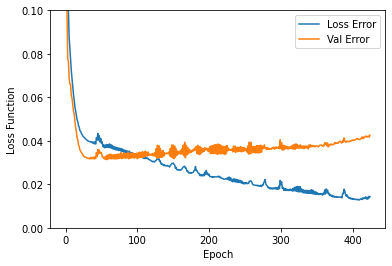

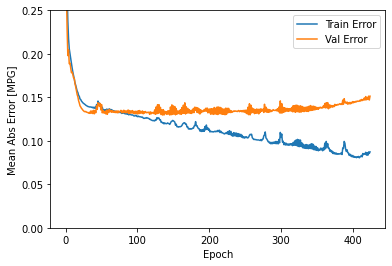

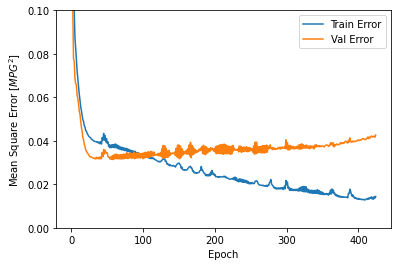

In [46]:
plot_history(history_lstm, 0, 0.1, 0.25, 0.1)

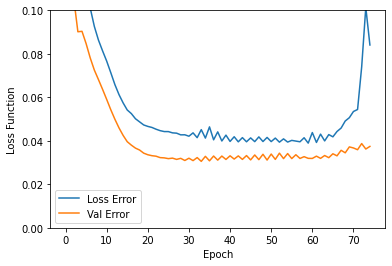

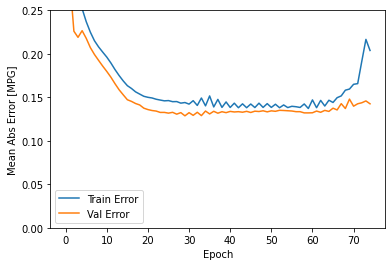

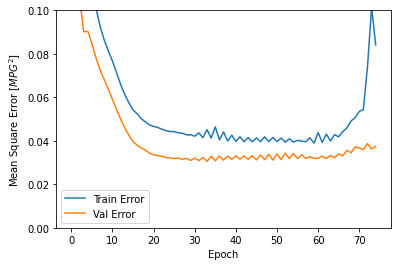

In [47]:
plot_history(history_lstm_ret_seq, 0, 0.1, 0.25, 0.1)

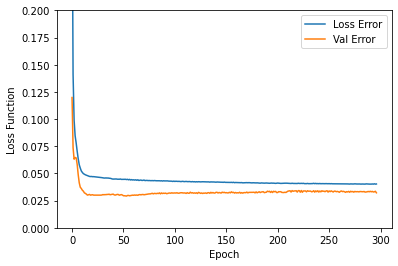

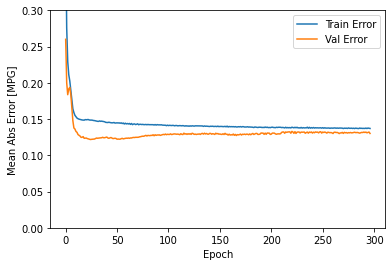

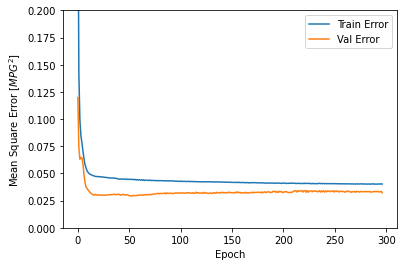

In [48]:
plot_history(history_cnn, 0, 0.2, 0.3, 0.2)

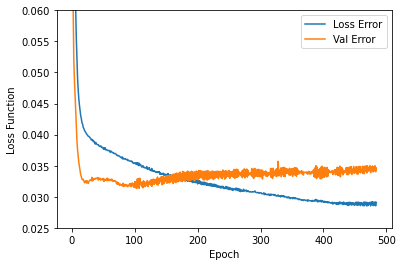

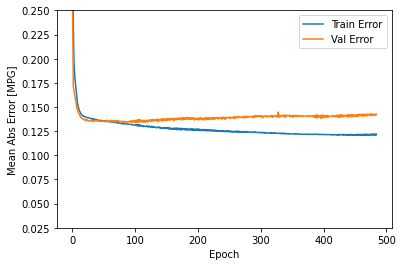

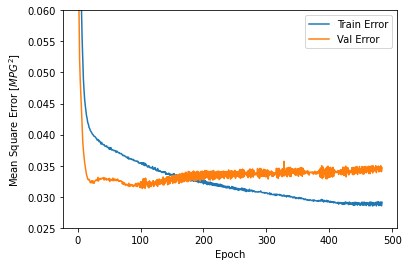

In [49]:
plot_history(history_cnn_relu, 0.025, 0.06, 0.25, 0.06)

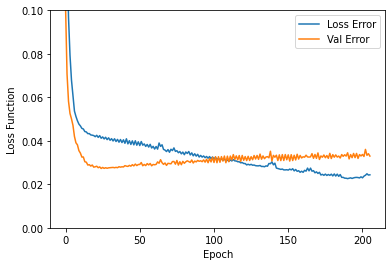

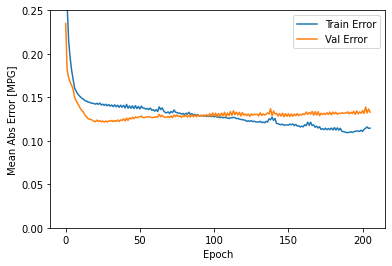

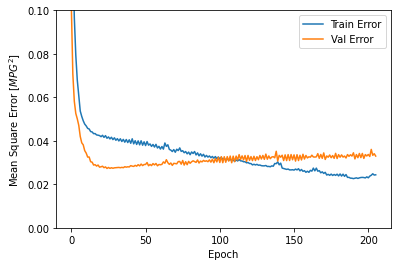

In [50]:
plot_history(history_gru, 0, 0.1, 0.25, 0.1)

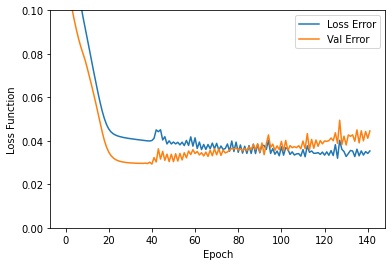

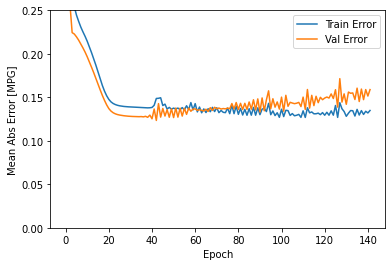

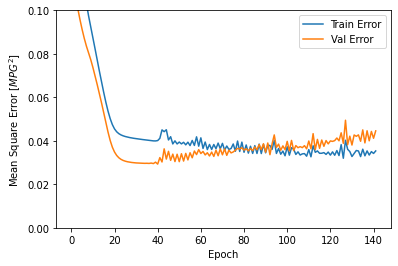

In [51]:
plot_history(history_lstm_unrestricted, 0, 0.1, 0.25, 0.1)

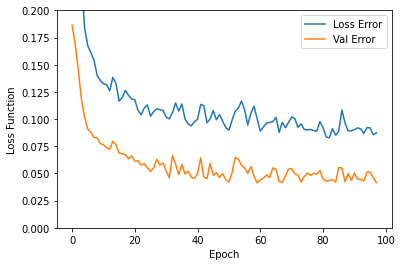

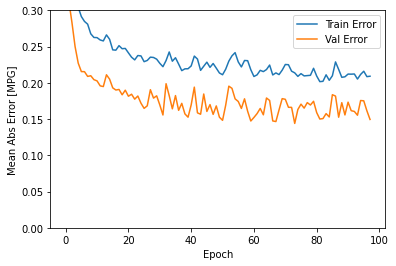

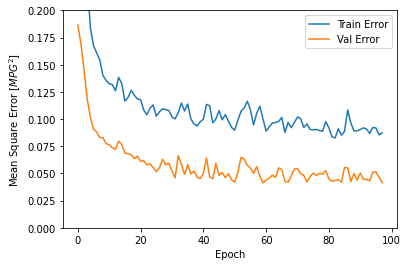

In [52]:
plot_history(history_lstm_dropout, 0, 0.2, 0.3, 0.2)

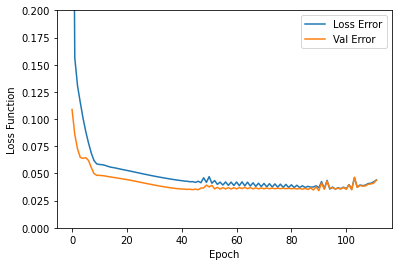

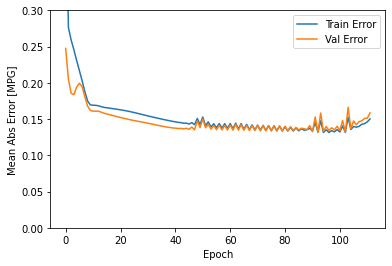

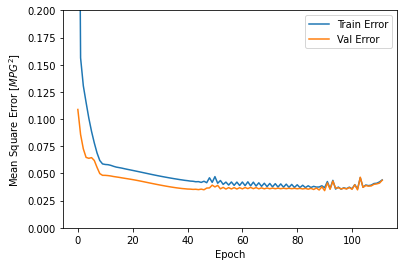

In [53]:
plot_history(history_lstm_go_bwd, 0, 0.2, 0.3, 0.2)

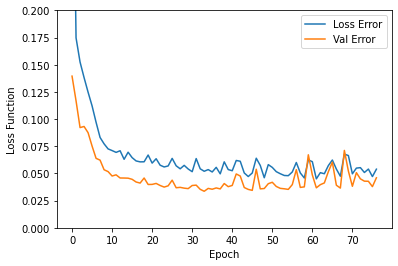

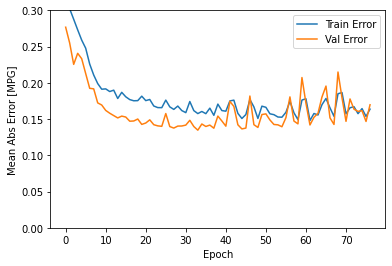

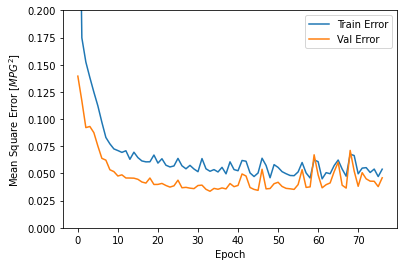

In [54]:
plot_history(history_lstm_bi, 0, 0.2, 0.3, 0.2)

In [55]:
def history_to_hist(history, string):
    hist = pd.DataFrame(history.history)
    temp = pd.to_numeric(hist[string], errors='coerce')
    res = []
    for i in range(temp.size):
        res.append(temp[i])
    return res

In [56]:
hist_lstm_loss = np.mean(history_to_hist(history_lstm, "loss"))
hist_cnn_loss = np.mean(history_to_hist(history_cnn, "loss"))
hist_gru_loss = np.mean(history_to_hist(history_gru, "loss"))
hist_lstm_ret_seq_loss = np.mean(history_to_hist(history_lstm_ret_seq, "loss"))
hist_cnn_relu_loss = np.mean(history_to_hist(history_cnn_relu, "loss"))
hist_lstm_unrestricted_loss = np.mean(history_to_hist(history_lstm_unrestricted, "loss"))
hist_lstm_dropout_loss = np.mean(history_to_hist(history_lstm_dropout, "loss"))
hist_lstm_go_bwd_loss = np.mean(history_to_hist(history_lstm_go_bwd, "loss"))
hist_lstm_bi_loss = np.mean(history_to_hist(history_lstm_bi, "loss"))

In [57]:
hist_lstm_loss_val = np.mean(history_to_hist(history_lstm, "val_loss"))
hist_cnn_loss_val = np.mean(history_to_hist(history_cnn, "val_loss"))
hist_gru_loss_val = np.mean(history_to_hist(history_gru, "val_loss"))
hist_lstm_ret_seq_loss_val = np.mean(history_to_hist(history_lstm_ret_seq, "val_loss"))
hist_cnn_relu_loss_val = np.mean(history_to_hist(history_cnn_relu, "val_loss"))
hist_lstm_unrestricted_loss_val = np.mean(history_to_hist(history_lstm_unrestricted, "val_loss"))
hist_lstm_dropout_loss_val = np.mean(history_to_hist(history_lstm_dropout, "val_loss"))
hist_lstm_go_bwd_loss_val = np.mean(history_to_hist(history_lstm_go_bwd, "val_loss"))
hist_lstm_bi_loss_val = np.mean(history_to_hist(history_lstm_bi, "val_loss"))

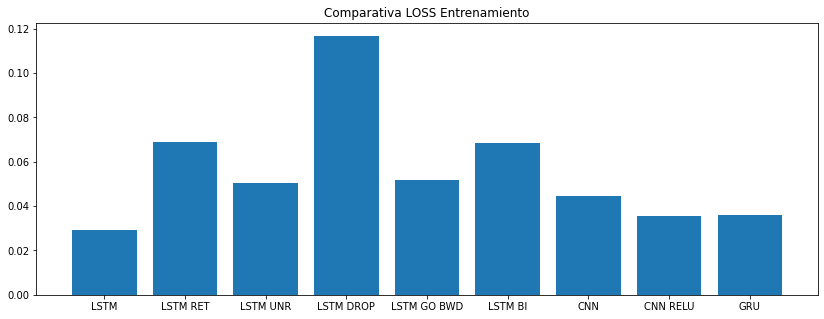

In [58]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [hist_lstm_loss, hist_lstm_ret_seq_loss, hist_lstm_unrestricted_loss, hist_lstm_dropout_loss, hist_lstm_go_bwd_loss, hist_lstm_bi_loss, hist_cnn_loss, hist_cnn_relu_loss, hist_gru_loss]
plt.figure(figsize=(14,5))
plt.title("Comparativa LOSS Entrenamiento")
plt.bar(x_axis, y_axis)
plt.show()

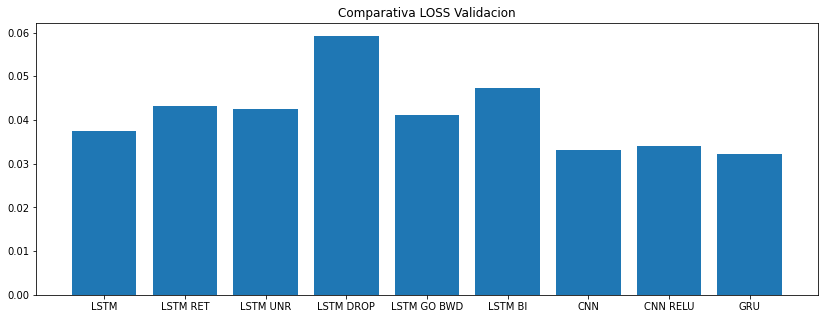

In [59]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "CNN", "CNN RELU", "GRU"]
y_axis = [hist_lstm_loss_val, hist_lstm_ret_seq_loss_val, hist_lstm_unrestricted_loss_val, hist_lstm_dropout_loss_val, hist_lstm_go_bwd_loss_val, hist_lstm_bi_loss_val, hist_cnn_loss_val, hist_cnn_relu_loss_val, hist_gru_loss_val]
plt.figure(figsize=(14,5))
plt.title("Comparativa LOSS Validacion")
plt.bar(x_axis, y_axis)
plt.show()

In [60]:
y_pred_lstm = model_lstm.predict(x_test_norm)

In [61]:
y_pred_cnn = model_cnn.predict(x_test_norm)
y_pred_gru = model_gru.predict(x_test_norm)
y_pred_lstm_ret_seq = model_lstm_ret_seq.predict(x_test_norm)
y_pred_cnn_relu = model_cnn_relu.predict(x_test_norm)

In [62]:
y_pred_lstm_unrestricted = model_lstm_unrestricted.predict(x_test_norm)

In [63]:
y_pred_lstm_dropout = model_lstm_dropout.predict(x_test_norm)

In [64]:
y_pred_lstm_go_bwd = model_lstm_go_bwd.predict(x_test_norm)

In [65]:
y_pred_lstm_bi = model_lstm_bi.predict(x_test_norm)

In [66]:
def inverse_standarize_input(arr):
    arr = (arr * y_std) + y_mean
    return arr

In [67]:
y_pred_lstm = inverse_standarize_input(y_pred_lstm)
y_pred_cnn = inverse_standarize_input(y_pred_cnn)
y_pred_gru = inverse_standarize_input(y_pred_gru)
y_pred_lstm_ret_seq = inverse_standarize_input(y_pred_lstm_ret_seq)
y_pred_cnn_relu = inverse_standarize_input(y_pred_cnn_relu)
y_test = inverse_standarize_input(y_test_norm)

In [68]:
y_pred_lstm_unrestricted = inverse_standarize_input(y_pred_lstm_unrestricted)

In [69]:
y_pred_lstm_bi = inverse_standarize_input(y_pred_lstm_bi)

In [70]:
y_pred_lstm_dropout = inverse_standarize_input(y_pred_lstm_dropout)

In [71]:
y_pred_lstm_go_bwd = inverse_standarize_input(y_pred_lstm_go_bwd)

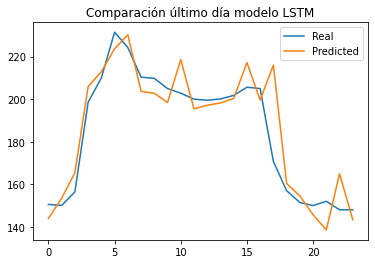

In [72]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM")
plt.legend()

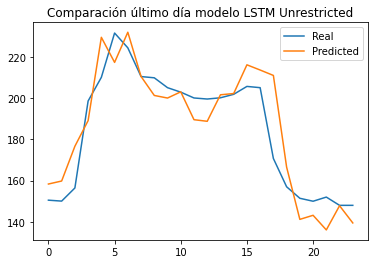

In [73]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_unrestricted[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Unrestricted")
plt.legend()

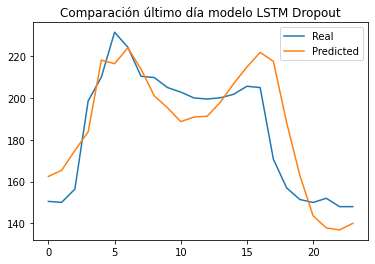

In [74]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_dropout[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Dropout")
plt.legend()

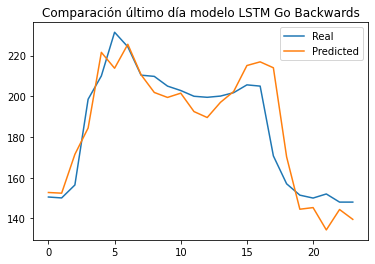

In [75]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_go_bwd[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM Go Backwards")
plt.legend()

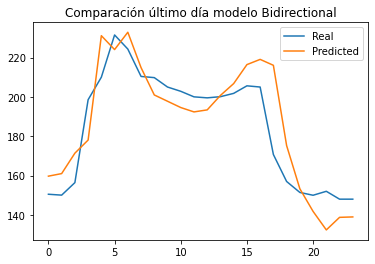

In [76]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_bi[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo Bidirectional")
plt.legend()

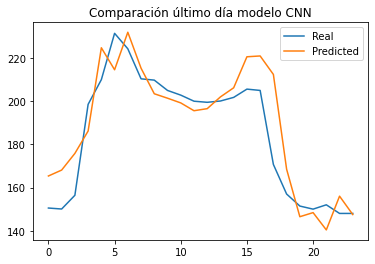

In [77]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN")
plt.legend()

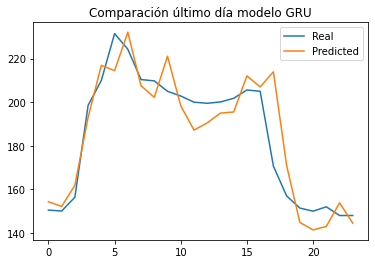

In [78]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_gru[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo GRU")
plt.legend()

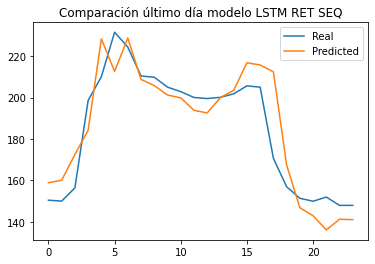

In [79]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_lstm_ret_seq[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo LSTM RET SEQ")
plt.legend()

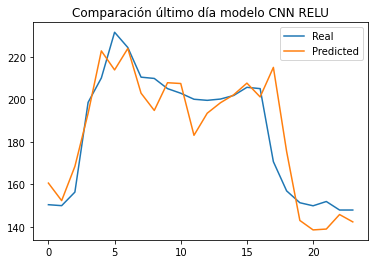

In [80]:
plt.plot(y_test[((y_test.size) - 24):], label='Real')
plt.plot(y_pred_cnn_relu[((y_test.size) - 24):], label='Predicted')
plt.title("Comparación último día modelo CNN RELU")
plt.legend()

In [81]:
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_cnn = np.sqrt(mean_squared_error(y_test, y_pred_cnn))
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_lstm_ret_seq = np.sqrt(mean_squared_error(y_test, y_pred_lstm_ret_seq))
mae_lstm_ret_seq = mean_absolute_error(y_test, y_pred_lstm_ret_seq)
rmse_cnn_relu = np.sqrt(mean_squared_error(y_test, y_pred_cnn_relu))
mae_cnn_relu = mean_absolute_error(y_test, y_pred_cnn_relu)
rmse_lstm_unrestricted = np.sqrt(mean_squared_error(y_test, y_pred_lstm_unrestricted))
mae_lstm_unrestricted = mean_absolute_error(y_test, y_pred_lstm_unrestricted)
rmse_lstm_dropout = np.sqrt(mean_squared_error(y_test, y_pred_lstm_dropout))
mae_lstm_dropout = mean_absolute_error(y_test, y_pred_lstm_dropout)
rmse_lstm_go_bwd = np.sqrt(mean_squared_error(y_test, y_pred_lstm_go_bwd))
mae_lstm_go_bwd = mean_absolute_error(y_test, y_pred_lstm_go_bwd)
rmse_lstm_bi = np.sqrt(mean_squared_error(y_test, y_pred_lstm_bi))
mae_lstm_bi = mean_absolute_error(y_test, y_pred_lstm_bi)

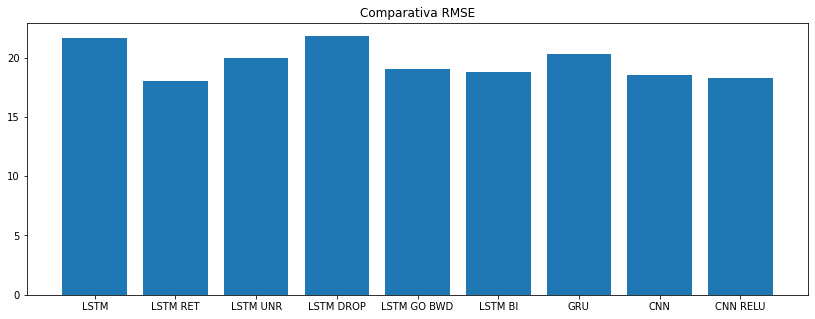

In [82]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "GRU", "CNN", "CNN RELU"]
y_axis = [rmse_lstm, rmse_lstm_ret_seq, rmse_lstm_unrestricted, rmse_lstm_dropout, rmse_lstm_go_bwd, rmse_lstm_bi, rmse_gru, rmse_cnn, rmse_cnn_relu]
plt.figure(figsize=(14,5))
plt.title("Comparativa RMSE")
plt.bar(x_axis, y_axis)
plt.show()

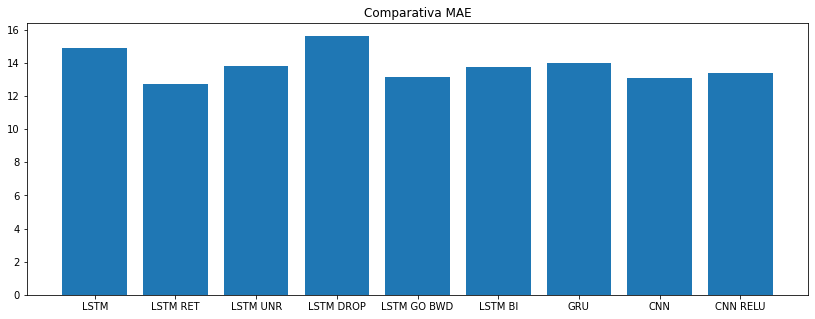

In [83]:
x_axis = ["LSTM", "LSTM RET", "LSTM UNR", "LSTM DROP", "LSTM GO BWD", "LSTM BI", "GRU", "CNN", "CNN RELU"]
y_axis = [mae_lstm, mae_lstm_ret_seq, mae_lstm_unrestricted, mae_lstm_dropout, mae_lstm_go_bwd, mae_lstm_bi, mae_gru, mae_cnn, mae_cnn_relu]
plt.figure(figsize=(14,5))
plt.title("Comparativa MAE")
plt.bar(x_axis, y_axis)
plt.show()

In [84]:
model_lstm.save("normalized_multiple_input_2022/LSTM.h5")
model_cnn.save("normalized_multiple_input_2022/CNN.h5")
model_gru.save("normalized_multiple_input_2022/GRU.h5")
model_lstm_ret_seq.save("normalized_multiple_input_2022/LSTM_RET_SEQ.h5")
model_cnn_relu.save("normalized_multiple_input_2022/CNN_RELU.h5")
model_lstm_unrestricted.save("normalized_multiple_input_2022/LSTM_UNRESTRICTED.h5")
model_lstm_dropout.save("normalized_multiple_input_2022/LSTM_DROPOUT.h5")
model_lstm_go_bwd.save("normalized_multiple_input_2022/LSTM_GO_BWD.h5")
model_lstm_bi.save("normalized_multiple_input_2022/LSTM_BI.h5")

In [85]:
print(rmse_lstm)

21.6072431444841


In [86]:
# saved_model_lstm_unr = tf.keras.models.load_model("normalized_multiple_input_2022/LSTM_UNRESTRICTED.h5")

In [87]:
# tf.saved_model.save(saved_model_lstm_unr, "/models")
model_lstm_unrestricted.save("prueba")

2022-06-16 10:20:20.421927: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: prueba/assets


INFO:tensorflow:Assets written to: prueba/assets


In [88]:
df['date'] = timestamp

In [89]:
for i in df.index:
        df.at[i, 'price'] = (df.at[i, 'price'] - x_mean) / x_std

In [90]:
print(df.head)

<bound method NDFrame.head of           price       day_sin       day_cos      week_sin  week_cos  year_sin  \
43104  0.946726 -2.588190e-01  9.659258e-01  9.749279e-01 -0.222521 -0.671089   
43105  0.539542 -1.093976e-11  1.000000e+00 -9.749279e-01 -0.222521  0.962712   
43106  0.366099  2.588190e-01  9.659258e-01  7.818315e-01  0.623490 -0.959032   
43107  0.186153  5.000000e-01  8.660254e-01 -4.338837e-01 -0.900969  0.661178   
43108 -0.256533  7.071068e-01  7.071068e-01  5.665657e-10  1.000000 -0.160514   
...         ...           ...           ...           ...       ...       ...   
47298 -0.768189 -9.659258e-01 -2.588190e-01 -9.749279e-01 -0.222521  0.950645   
47299 -0.337834 -1.000000e+00 -1.283175e-11  7.818315e-01  0.623490 -0.969970   
47300  0.014471 -9.659258e-01  2.588190e-01 -4.338837e-01 -0.900969  0.691766   
47301 -0.099215 -8.660254e-01  5.000000e-01  4.569656e-09  1.000000 -0.201370   
47302 -0.431331 -7.071068e-01  7.071068e-01  4.338837e-01 -0.900969 -0.350795  

In [91]:
df.to_csv (r'csvdata2022.csv', index = False, header=True)

In [96]:
print(y_test[-1])
print(y_pred_lstm_unrestricted[-1])

[148.]
[139.47815]
